In [1]:
import warnings  # 忽略无意义的警告

def ignore_warn(*arfs, **kwargs):
    pass

warnings.warn = ignore_warn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
train=pd.read_csv(r'C:\Users\11946\Desktop\train.csv')# 读取训练集数据
test=pd.read_csv(r'C:\Users\11946\Desktop\test.csv') # 读取测试集数据
id = test['Id']
train.drop(['Id'],axis=1,inplace=True)
test.drop(['Id'],axis=1,inplace=True)

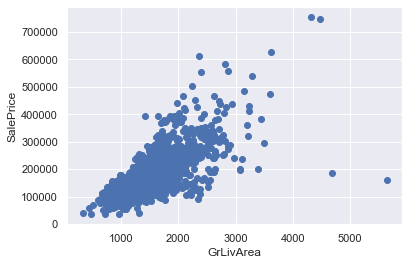

In [3]:
sns.set(style='darkgrid')  # 设置图片背景
fig = plt.figure()  # 使用plt作图工具
ax = plt.scatter(train['GrLivArea'], train['SalePrice'])  # 使用散点图观察房价与居住面积的关系
plt.xlabel('GrLivArea')  # 设置横坐标
plt.ylabel('SalePrice')  # 设置纵坐标
plt.show()  # 图片显示

In [4]:
# 删除居住面积大于4000的数据
train = train.drop(train[train['GrLivArea'] > 4000].index)

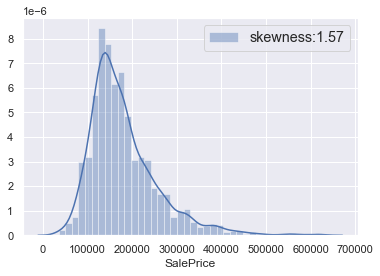

In [5]:
# 房价是连续的属性，使用 Seaborn 绘图观察数据分布
g = sns.distplot(train['SalePrice'], kde=True, label='skewness:%.2f' %
                 train['SalePrice'].skew())  # 绘制柱状图，kde=True表示绘制拟合曲线，skew()函数计算房价的偏态系数
plt.legend(loc='best', fontsize='large')  # 设置 legend 的位置和大小
g.set(xlabel='SalePrice')  # 设置横坐标
plt.show()

In [6]:
# 房价属于右偏态分布，使用 Log Transformation 方法
train['SalePrice'] = np.log(train['SalePrice'])  # 对房价取对数
train['SalePrice'].skew()  # 检查新数据偏态系数

0.06544882031646646

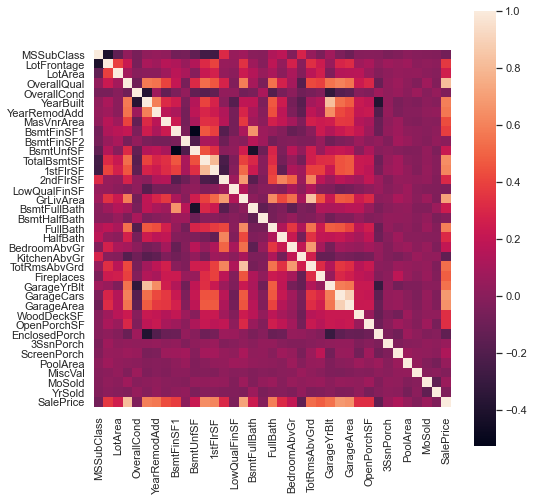

In [7]:
# 关联系数
plt.subplots(figsize=(8, 8))  # 设置图形大小
sns.heatmap(train.corr(), square=True)  # corr()函数计算关联系数，并绘图
plt.show()

In [8]:
data = pd.concat([train, test], axis=0, ignore_index=True)
# 合并测试集和训练集，命名为data

In [9]:
# 缺失值
def null_count(data):  # 定义 null 值查找函数，函数名 null_count
    null_data = data.isnull().sum()  # 查找各个特征 null 值并计算数量
    null_data = null_data.drop(null_data[null_data == 0].index).sort_values(
        ascending=False)  # 删除数目为零的特征，降序排列
    return null_data  # 返回结果

null_count(data)  # 调用 null_count 函数统计 data 的 null，输出结果

PoolQC          2907
MiscFeature     2810
Alley           2717
Fence           2345
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageYrBlt      159
GarageFinish     159
GarageQual       159
GarageCond       159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
Utilities          2
BsmtFinSF2         1
BsmtUnfSF          1
BsmtFinSF1         1
TotalBsmtSF        1
SaleType           1
KitchenQual        1
Exterior2nd        1
Exterior1st        1
GarageCars         1
GarageArea         1
Electrical         1
dtype: int64

In [10]:
a = 0
# 查找所有 BsmtCond 缺失的样例所对应 TotalBsmtSF 值
null_set = data[data['BsmtCond'].isnull()]['TotalBsmtSF']
for i in null_set:  # 统计其中 TotalBsmtSF 大于0的样例的数目
    if i != 0:
        a += 1
print(a)  # a 如果还等于零，说明 BsmtCond 的 null 值全部是原因一造成的

4


In [11]:
No_inplace = ['Alley', 'FireplaceQu', 'Fence']
for feature in No_inplace:
    data[feature].fillna('U', inplace=True)  # 使用 ‘U’ null 值

In [12]:
# 定义函数sp_null_index，用来查找由原因二导致缺失的数据的 index，以列表形式返回。输入变量为：数据集 data，特征 feature，用来判断的特征 judge_feature, 判断阈值 judge_value
def sp_null_index(data, feature, judge_feature, judge_value):
    # 查找缺失值的 index，列表名 null_index
    null_index = data[data[feature].isnull()].index
    sp_index = [i for i in null_index if data[judge_feature][i] !=
                judge_value]  # Python 列表推导式。查找 null_index 中属于原因二的 index
    return sp_index  # 返回结果

# 定义 fill_null 函数，分类填充 null 值。输入变量：特征列表 features 缺失值分类填充，replace_value 为原因一填充值，其它与上同
def fill_null(data, features, judge_feature, judge_value, replace_value):
    for feature in features:
        # 调用 sp_null_index 获取原因二导致的 index 集合，命名为 sp_index
        sp_index = sp_null_index(data, feature, judge_feature, judge_value)
        # 所有 null 值使用 replace_value 填充
        data[feature].fillna(replace_value, inplace=True)
        for i in sp_index:  # sp_index 中 index 的数据使用众数替换
            data[feature].iloc[i] = data[feature].mode()[0]
    return data  # 返回填充好的数据集 data

zero_replace = ['BsmtHalfBath', 'BsmtHalfBath',
                'BsmtFullBath', 'BsmtUnfSF', 'TotalBsmtSF','BsmtFinSF2','BsmtFinSF1']  # 这些属性将使用0填充
for feature in zero_replace:
    data[feature].fillna(0.0, inplace=True)

features = ['BsmtQual', 'BsmtCond', 'BsmtExposure',
            'BsmtFinType1', 'BsmtFinType2']
# 调用 fill_null 函数分类填充
data = fill_null(data, features, 'TotalBsmtSF', 0.0, 'U')

In [13]:
data = fill_null(data, ['PoolQC'], 'PoolArea', 0, 'U')

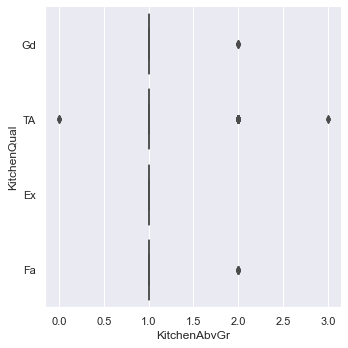

In [14]:
g = sns.factorplot(x='KitchenAbvGr', y='KitchenQual', data=data,
                   kind='box')  # 绘制箱型图观察 KitchenQual 与其他属性的关系
# itchenAbvGr 特征值为1，根据下图，null 使用众数补全。
data[data['KitchenQual'].isnull()]['KitchenAbvGr']
plt.show()

In [15]:
mode_inplace = ['MSZoning', 'Utilities', 'Exterior1st', 'Electrical',
                'Exterior2nd', 'KitchenQual', 'SaleType']  # 这些属性使用众数补全
for feature in mode_inplace:
    data[feature].fillna(data[feature].mode()[0], inplace=True)

In [16]:
data['Functional'].fillna('Typ',inplace=True)

In [17]:
# MasVnrType 和 MasVnrArea 都缺失的可以看做没有 Masory
data[data['MasVnrType'].isnull()]['MasVnrArea']

234       NaN
528       NaN
649       NaN
934       NaN
971       NaN
975       NaN
1240      NaN
1275      NaN
1687      NaN
1702      NaN
1878      NaN
1988      NaN
2000      NaN
2037      NaN
2307      NaN
2321      NaN
2336      NaN
2345      NaN
2364      NaN
2588      NaN
2606    198.0
2653      NaN
2682      NaN
2858      NaN
Name: MasVnrArea, dtype: float64

In [18]:
data['MasVnrArea'].fillna(0.0, inplace=True)
data = fill_null(data, ['MasVnrType'], 'MasVnrArea', 0.0, 'U')

In [19]:
for feature in ['GarageCars', 'GarageArea']:
    # GarageCars，GarageArea null 值由原因二产生，使用众数替代
    data[feature].fillna(data[feature].mode()[0], inplace=True)
# GarageType 缺失值看做没有 Garage, 使用 ‘U’ 替代。
data['GarageType'].fillna('U', inplace=True)
features = ['GarageFinish', 'GarageQual', 'GarageCond']
data = fill_null(data, features, 'GarageType', 'U', 'U')  # 没有 Garage 使用‘U’替代，否则使用众数替代。
# 没有 Garage 的 GarageYrBlt 使用0替代，否则使用众数替代。
data = fill_null(data, ['GarageYrBlt'], 'GarageType', 'U', 0)

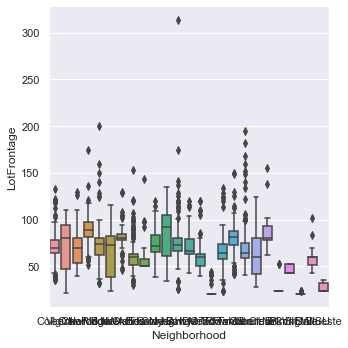

In [20]:
# 绘图观察 Neighborhood 与 LotFrontage 关系
g = sns.factorplot(x='Neighborhood', y='LotFrontage', data=data, kind='box')
data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda i: i.fillna(i.median()))  # 分组并使用均值替换 null 值
plt.show()

In [21]:
data['MiscFeature'].fillna('U',inplace=True)

In [22]:
data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + \
    data['2ndFlrSF']  # 增加特征 TotalSF （地下室、一层、二层面积之和））

In [23]:
from sklearn.preprocessing import LabelEncoder
features = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
            'ExterQual', 'ExterCond', 'HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
            'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope']
for feature in features:
    le = LabelEncoder()
    le.fit(data[feature].values)
    data[feature] = le.transform(data[feature].values)

In [24]:
features = ['MSSubClass', 'YrSold',
            'GarageYrBlt', 'MoSold']  # 这四个离散的数据特征转换为字符串类型
for feature in features:
    data[feature] = data[feature].apply(str)  # 转换为字符串类型
skew = {}  # 建立空字典
for feature in data.columns:
    if data[feature].dtype != 'O':  # 对非字符串类型的数据计算偏态系数
        a = float('%.2f' % data[feature].skew())  # 计算偏态系数
        if a > 1:  # 如果偏态系数大于1，储存在字典中
            skew[feature] = a
skew  # 显示

{'LotFrontage': 1.09,
 'LotArea': 13.13,
 'LandSlope': 4.97,
 'MasVnrArea': 2.6,
 'BsmtFinSF2': 4.14,
 '1stFlrSF': 1.25,
 'LowQualFinSF': 12.09,
 'BsmtHalfBath': 3.94,
 'KitchenAbvGr': 4.3,
 'WoodDeckSF': 1.85,
 'OpenPorchSF': 2.53,
 'EnclosedPorch': 4.0,
 '3SsnPorch': 11.37,
 'ScreenPorch': 3.95,
 'PoolArea': 18.71,
 'MiscVal': 21.94}

In [25]:
from scipy.special import boxcox1p  # 导入 box-cox transformation 模块
lam = 0.1
for feature in skew.keys():
    data[feature] = boxcox1p(data[feature], lam)  # box-cox transformation

In [26]:
data = pd.get_dummies(data) # 对 data 中字符串类型的数据数值化

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso

l_train = len(data[data['SalePrice'].notnull()])  # 训练集长度
train = data[:l_train]  # 训练集
y = train['SalePrice']  # 预测目标
X = train.drop('SalePrice', axis=1).values  # 特征向量

In [28]:
# 方法一：Lasso算法
clf = Lasso(alpha=0.0005)  # 参数设置
clf.fit(X, y)  # 训练模型
print('特征总数：%d' % len(data.columns))
print('嵌入式选择后，保留特征数：%d' % np.sum(clf.coef_ != 0))  # 计算并显示嵌入式选择后，保留的特征数。

特征总数：366
嵌入式选择后，保留特征数：119


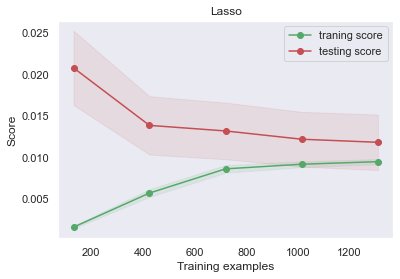

In [29]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
%matplotlib inline

def plot_learning_curve(estimator, title, X, y, cv=10,
                        train_sizes=np.linspace(.1, 1.0, 5)):  # 定义 plot_learning_curve 函数绘制学习曲线
    plt.figure()
    plt.title(title)  # 图片标题
    plt.xlabel('Training examples')  # 横坐标
    plt.ylabel('Score')  # 纵坐标
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring="neg_mean_squared_error",
                                                            train_sizes=train_sizes)  # 交叉验证法计算训练误差，测试误差
    train_scores_mean = np.mean(-train_scores, axis=1)  # 计算训练误差平均值
    train_scores_std = np.std(-train_scores, axis=1)  # 训练误差方差
    test_scores_mean = np.mean(-test_scores, axis=1)  # 测试误差平均值
    test_scores_std = np.std(-test_scores, axis=1)  # 测试误差方差
    plt.grid()  # 增加网格

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1, color='g')  # 颜色填充
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1, color='r')  # 颜色填充
    plt.plot(train_sizes, train_scores_mean, 'o-', color='g',
             label='traning score')  # 绘制训练误差曲线
    plt.plot(train_sizes, test_scores_mean, 'o-', color='r',
             label='testing score')  # 绘制测试误差曲线
    plt.legend(loc='best')
    return plt

clf = Lasso(alpha=0.0005)
g = plot_learning_curve(clf, 'Lasso', X, y)  # 调用 plot_learning_curve 绘制学习曲线

In [30]:
clf = Lasso(alpha=0.0005)  # 参数设置
clf.fit(X, y)
test = data[l_train:].drop('SalePrice', axis=1).values  # 测试集数据
predict1 = np.exp(clf.predict(test))  # 预测
resul = pd.DataFrame()
resul['Id'] = id
resul['SalePrice'] = predict1
resul.to_csv(r'C:\Users\11946\Desktop\submission1.csv', index=False)  # 将结果写入 submission.csv

In [31]:
# 查看 submission.csv
pd.read_csv(r'C:\Users\11946\Desktop\submission1.csv')

,Id,SalePrice
0,1461,122142.834827
1,1462,156578.110759
2,1463,186803.731526
3,1464,200948.630441
4,1465,197812.756541
...,...,...
1454,2915,89047.081700
1455,2916,80900.771168
1456,2917,166014.159531
1457,2918,120281.592832


In [32]:
# 方法二：随机森林算法
from sklearn import preprocessing
from sklearn import linear_model, svm, gaussian_process
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
Max_features = [.1,.3,.5,.7,.9,.99]
test_scores2 = []
for feature in Max_features:
    RFR = RandomForestRegressor(n_estimators = 200,max_features = feature)
    test_score  = cross_val_score(RFR, X, y, cv=5)

    test_scores2.append(test_score.mean())
test_scores2

[0.8857830048799205,
 0.8897888078438703,
 0.8893799698831103,
 0.8859288766301707,
 0.8816180569934347,
 0.880259755520845]

In [34]:
# 可以看到当feature = 0.5时，评分最高，因此建立模型对y进行预测
test = data[l_train:].drop('SalePrice', axis=1).values  # 测试集数据
RFR = RandomForestRegressor(n_estimators = 200,max_features = 0.5)
clf = RFR.fit(X, y)
predict2 = np.exp(clf.predict(test))  # 预测
resu2 = pd.DataFrame()
resu2['Id'] = id
resu2['SalePrice'] = predict2
resu2.to_csv(r'C:\Users\11946\Desktop\submission2.csv', index=False)  # 将结果写入 submission.csv

In [35]:
# 查看 submission.csv
pd.read_csv(r'C:\Users\11946\Desktop\submission2.csv')

,Id,SalePrice
0,1461,125984.364498
1,1462,157207.150801
2,1463,179851.977462
3,1464,181728.642598
4,1465,194454.466468
...,...,...
1454,2915,87325.455674
1455,2916,86151.785896
1456,2917,162792.086831
1457,2918,116125.543119


In [36]:
# 方法三：ElasticNet算法
# =========================================================================
from sklearn import preprocessing
from sklearn import linear_model, svm, gaussian_process
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
alphas = [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10]
test_scores = []
for alpha in alphas:
    ElasticN = linear_model.ElasticNetCV(alphas=[alpha],
                                    l1_ratio=[.01, .1, .5, .9, .99],
                                    max_iter=5000)
    test_score  = cross_val_score(ElasticN, X, y, cv=5)

    test_scores.append(test_score.mean())
test_scores

[0.9135507618033705,
 0.9228744248953704,
 0.9226105414997985,
 0.9198343962278035,
 0.9111217359206665,
 0.8787176906705596,
 0.8288151613154622]

In [45]:
# 尝试alpha选择[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10]，得到交叉验证的平均分数如上
# 可以看到当alpha=0.0005时得分最高
clf = linear_model.ElasticNetCV(alphas=[0.01],
                                    l1_ratio=[.01, .1, .5, .9, .99],
                                    max_iter=5000)  # 参数设置
clf.fit(X, y)  # 训练模型

ElasticNetCV(alphas=[0.01], l1_ratio=[0.01, 0.1, 0.5, 0.9, 0.99], max_iter=5000)

In [48]:
predict3 = np.exp(clf.predict(test))  # 预测
resu3 = pd.DataFrame()
resu3['Id'] = id
resu3['SalePrice'] = predict3
resu3.to_csv(r'C:\Users\11946\Desktop\submission3.csv', index=False)  # 将结果写入 submission.csv

In [49]:
pd.read_csv(r'C:\Users\11946\Desktop\submission3.csv')

,Id,SalePrice
0,1461,119795.561834
1,1462,152072.447245
2,1463,185827.351849
3,1464,198237.814924
4,1465,193040.766984
...,...,...
1454,2915,87930.818418
1455,2916,79977.884998
1456,2917,167663.094373
1457,2918,119896.102065


In [50]:
# 方法四：简单模型融合(ElasticNet算法 + 随机森林算法)
resu4 = pd.DataFrame()
resu4['Id'] = id
# predict2为ElasticNet算法预测结果，predict3为随机森林算法预测结果
resu4['SalePrice'] = (predict2 + predict3) / 2
resu4.to_csv(r'C:\Users\11946\Desktop\submission4.csv', index=False)  # 将结果写入 submission.csv

In [51]:
pd.read_csv(r'C:\Users\11946\Desktop\submission4.csv')

,Id,SalePrice
0,1461,122889.963166
1,1462,154639.799023
2,1463,182839.664655
3,1464,189983.228761
4,1465,193747.616726
...,...,...
1454,2915,87628.137046
1455,2916,83064.835447
1456,2917,165227.590602
1457,2918,118010.822592
